In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='white', palette='Dark2', font_scale=0.8)

### Loading the data

In [2]:
file_ = './main_table_of_Fourches_ligs_ERK2.pkl'
with open(file_, 'rb') as f:
    df_erk2_mols = pickle.load(f)
df_erk2_mols = df_erk2_mols.set_index('Name')
df_erk2_mols = df_erk2_mols.sort_values('pKi', ascending = False)

RDKit WARNING: [11:44:31] Enabling RDKit 2019.09.1 jupyter extensions


#### Get the names of each one of the precomputed descriptors

In [3]:
from rdkit.Chem import Descriptors
# MNQ descriptor's set goes from 1 to 42
names_MQN = ['MQN' + str(i) for i in range(1, 43)]

# Names of default included descriptors; fragment (fr_) descriptors ommited 
names_rdkit_descriptors_default = [x[0] for x in Descriptors._descList if x[0][:3] != 'fr_']
# Now concatenate the lists of names
names_all_rdkit_descriptors = names_rdkit_descriptors_default + ['CalcNumAtomStereoCenters',
                                'CalcNumUnspecifiedAtomStereoCenters',
                                'GetNumAtoms'] + names_MQN

print('Number of 2D RDKit descriptors', len(names_all_rdkit_descriptors))

Number of 2D RDKit descriptors 160


### Extract the set of descriptors from the main data table 

In [4]:
d = df_erk2_mols['2d_rdkit'].map(lambda x: x)
df_rdkit_all = pd.DataFrame.from_dict(dict(zip(d.index, d.values))).T
df_rdkit_all.columns = names_all_rdkit_descriptors
df_rdkit_all.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
CSAR_erk2_18,12.715656,-0.475203,12.715656,0.182531,0.492792,393.491,366.275,393.216475,152.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
erk2_54,13.405604,-0.745597,13.405604,0.083856,0.327709,459.308,442.172,458.071259,158.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
CSAR_erk2_20,12.732601,-0.584261,12.732601,0.017665,0.346052,443.935,417.727,443.172417,164.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
CSAR_erk2_17,12.673357,-3.485752,12.673357,0.055118,0.318735,464.935,443.767,464.103352,164.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
erk2_52,12.796961,-0.485488,12.796961,0.191864,0.321240,441.535,414.319,441.216475,168.0,0.0,...,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_rdkit_all.info()
# All values are float

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, CSAR_erk2_18 to erk2_01
Columns: 160 entries, MaxEStateIndex to MQN42
dtypes: float64(160)
memory usage: 109.4+ KB


# KNIME

In [6]:
rdk2d_knime = pd.read_csv('knime/2d_rdki_knime.csv')
rdk2d_knime = rdk2d_knime.set_index('row ID')
# Reorder by pki values 
rdk2d_knime = rdk2d_knime.reindex(df_rdkit_all.index)

In [7]:
# includes both int and float variables
rdk2d_knime.head()

,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
CSAR_erk2_18,3.37224,113.7864,170.169065,102.93,393.491,393.216475,7,4,7,4,...,0,0,1,2,0,0,0,0,0,0
erk2_54,4.98110,117.5234,186.581620,93.80,459.308,458.071259,6,4,6,4,...,0,0,2,2,0,0,0,0,0,0
CSAR_erk2_20,3.07972,120.0882,185.266565,123.16,443.935,443.172417,8,5,9,5,...,0,0,1,2,0,0,0,0,0,0
CSAR_erk2_17,1.77302,116.9029,183.658279,149.10,464.935,464.103352,10,5,8,5,...,0,0,1,2,0,0,0,0,0,0
erk2_52,4.54952,129.3934,192.496275,102.93,441.535,441.216475,7,4,8,4,...,0,0,1,3,0,0,0,0,0,0


### PCA

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

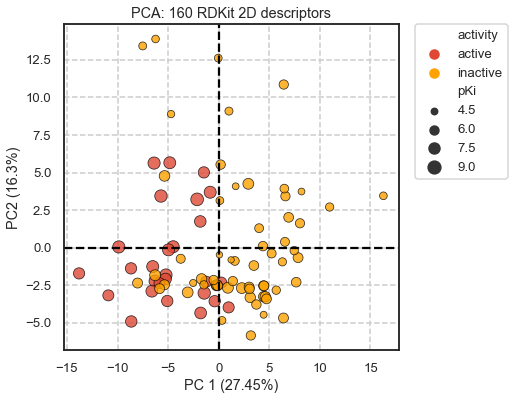

In [9]:
# Pipeline
scaler = StandardScaler()
pca = PCA(n_components=2)
pca_pipe = Pipeline(steps = [('scaler', scaler), ('pca', pca)])

X_rdk2d = rdk2d_knime
pca_pipe.fit(X_rdk2d)
# Components
components = pca_pipe.transform(X_rdk2d).T
# Variance ratio
var_ = (pca_pipe['pca'].explained_variance_ratio_ * 100).round(2)

df_pca = df_erk2_mols[['activity', 'pKi']].copy()
df_pca['activity'] = ['active' if i else 'inactive' for i in df_pca.activity]
df_pca['pc1'] = components[0]
df_pca['pc2'] = components[1]

# Plot the PCS
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvline(linestyle='--', color='k')
ax.axhline(linestyle='--', color='k')
sns.scatterplot(x='pc1', y='pc2', hue='activity', size='pKi', data=df_pca, 
                ax=ax, palette=['#df4834', '#fda200'], edgecolor='k', alpha=0.8)
ax.set(title='PCA: 160 RDKit 2D descriptors',
      xlabel=f'PC 1 ({var_[0]}%)', ylabel=f'PC2 ({var_[1]}%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='--')
plt.show()

## Feature Selection

**Selecting molecular descriptors following the Ash & Fourches (2017) procedure** (it is assumed that these steps were made independently for each set of descriptors):
1. **Low variance filter:** Features in the lower variance quartile were discarded.
    - This means that at least 25% of the features will be removed.
    
    
2. **Correlation filters:** For any pair of descriptors with $|r| > 0.9$ the descriptor with largest mean of $|r|$ was removed.

#### Additionally they did the following analysis (not necessarily to drop features):
1. **Pearson correlation between each descriptor and pKi values.**  
2. **Paired t-test between active and inactive ligands using each set of descriptors.**

### Variance Threshold


In [10]:
from sklearn.preprocessing import MinMaxScaler
# first scale the variables using min_max scaler
min_max_scaler = MinMaxScaler()

In [11]:
X_rdk2d_minmax = min_max_scaler.fit_transform(X_rdk2d)
variances = X_rdk2d_minmax.var(axis=0)
# Get the value of the first quartile
q1 = np.quantile(variances, 0.25)
# Variance filter
variance_filter = variances > q1
# Apply the filter
X_rdk2d_var = X_rdk2d.loc[:, variance_filter]

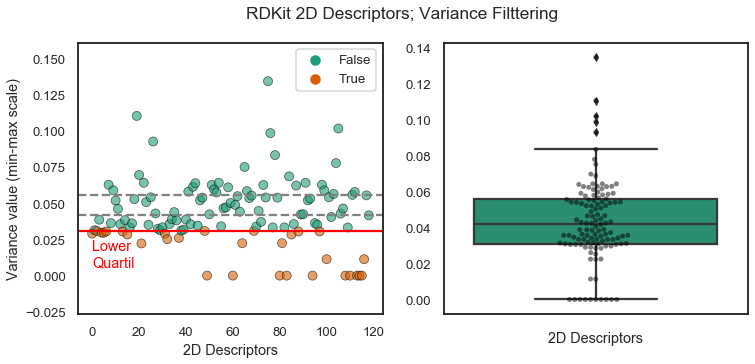

30 features were dropped.


In [12]:
# Plot variances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('RDKit 2D Descriptors; Variance Filttering')
q1, q2, q3 = np.quantile(variances, [0.25, 0.5, 0.75])
n_descriptors = X_rdk2d.shape[1]

ax1 = sns.scatterplot(x=range(0, n_descriptors), 
                      y=variances, ax=ax1, hue=(variances < q1),
                      edgecolor='k', alpha = 0.6)
ax1.set(xlabel='2D Descriptors', ylabel='Variance value (min-max scale)')
ax1.annotate('Lower\nQuartil', xy=(0, q1-.025), color='red')
ax1.axhline(q1, color='red')
ax1.axhline(q2, color='grey', linestyle='--')
ax1.axhline(q3, color='grey', linestyle='--')

ax2 = sns.boxplot(y=variances, ax=ax2)
ax2 = sns.swarmplot(y=variances, ax=ax2, color='black', alpha=0.5)
ax2.set(xlabel='2D Descriptors')
plt.show()

print(sum(variances <= q1), 'features were dropped.')

### Identifying binary features 

In [13]:
# Identify binary columns:
[col for col in X_rdk2d_var.columns if np.isin(X_rdk2d_var[col].unique(), [0, 1]).all() ]


['NumSaturatedRings',
 'NumSaturatedHeterocycles',
 'NumSaturatedCarbocycles',
 'NumAliphaticCarbocycles',
 'MQN15',
 'MQN25',
 'MQN29',
 'MQN33']

 These features have only zeros and ones, however,
 none of them are binary variables, i.e., they could take values different from 0 and 1
 
 In particular: 
 > MQN descriptors are '*Molecular quantitaive numbers*', which were defined by in
 'Classification of Organic Molecules by Molecular Quantum Numbers' by Nguyen, et al. (2009). DOI: 10.0.3.234/cmdc.200900317

## Z-score Standarization

In [14]:
# Standarization
scaler = StandardScaler()
X_rdk2d_std = pd.DataFrame(scaler.fit_transform(X_rdk2d_var), columns=X_rdk2d_var.columns, index=X_rdk2d_var.index)
X_rdk2d_std.shape

(87, 89)

## Correlation filtering (Pearson correlation coefficient)

#### Using the `caret` package

This time we are going to use the 'caret' package in R, the same package that Ash & Fourches used.

In [15]:
%load_ext rpy2.ipython

In [16]:
%%R -i X_rdk2d_std -o cols_to_drop

corr_mtx = cor(X_rdk2d_std, method='pearson')
cols_to_drop = caret::findCorrelation(corr_mtx, cutoff=0.9, exact=TRUE, names=TRUE)
cols_to_drop

 [1] "kappa1"            "kappa2"            "NumAtoms"         
 [4] "Chi0v"             "NumRotatableBonds" "SMR"              
 [7] "Chi1v"             "Chi1n"             "MQN20"            
[10] "Chi2n"             "MQN1"              "Chi3n"            
[13] "smr_VSA7"          "NumHBD"            "MQN23"            
[16] "NumLipinskiHBD"    "MQN17"             "smr_VSA2"         
[19] "MQN42"             "slogp_VSA7"       


In [17]:
# Drop the identified features by caret
X_rdk2d_corr = X_rdk2d_std.drop(cols_to_drop, axis=1)
X_rdk2d_corr.shape

(87, 69)

### Visualize correlation before and after removing features

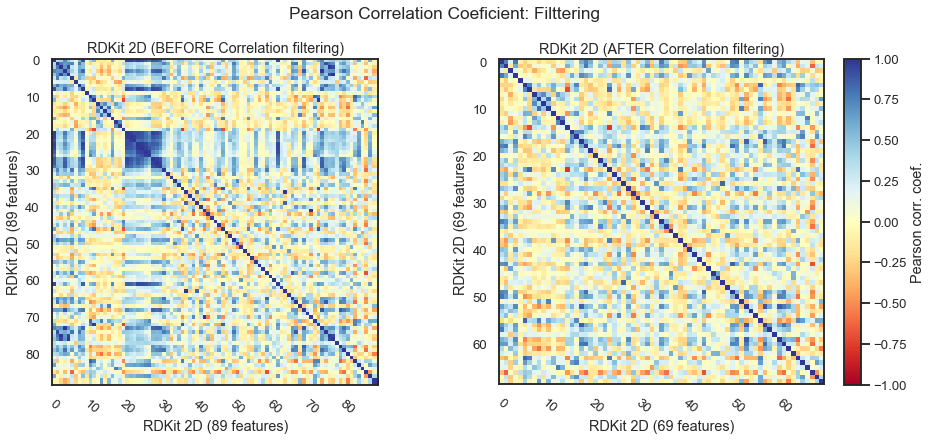

In [18]:
fig = plt.figure(figsize=(16, 6))
plt.suptitle('Pearson Correlation Coeficient: Filttering', y = 1.0)

# ALL FEATURES POST VARIANCE THR
n_init_feat = X_rdk2d_std.shape[1]
corr_mtx_all = X_rdk2d_std.corr(method='pearson')

plt.subplot(1, 2, 1)
plt.imshow(corr_mtx_all, cmap='RdYlBu', vmin=-1, vmax=1)
plt.yticks(range(0, n_init_feat, 10))
plt.xticks(range(0, n_init_feat, 10), rotation=-40)
axlabel_ = f'RDKit 2D ({n_init_feat} features)'
plt.xlabel(axlabel_); plt.ylabel(axlabel_)
plt.title('RDKit 2D (BEFORE Correlation filtering)')


# FEATURES POST CORR FILTERING
n_new_feat = X_rdk2d_corr.shape[1]
corr_mtx_post_corr = X_rdk2d_corr.corr(method='pearson')

plt.subplot(1, 2, 2)
plt.imshow(corr_mtx_post_corr, cmap='RdYlBu', vmin=-1, vmax=1)
plt.yticks(range(0, n_new_feat, 10))
plt.xticks(range(0, n_new_feat, 10), rotation=-40)
axlabel_ = f'RDKit 2D ({n_new_feat} features)'
plt.xlabel(axlabel_); plt.ylabel(axlabel_)
plt.title('RDKit 2D (AFTER Correlation filtering)')

cbar = plt.colorbar()
cbar.set_label('Pearson corr. coef.')
plt.show()

## Pearson Correlation of 68 descriptors with pKi values

In [19]:
from scipy.stats import pearsonr

In [20]:
rdk2d_corr_values_with_pki = [pearsonr(desc, df_erk2_mols.pKi) for i, desc in X_rdk2d_corr.iteritems()]

df_rdk2d_corr_corr_pki = pd.DataFrame({
          'descriptor': X_rdk2d_corr.columns,
          'corr_pearson': [i[0] for i in rdk2d_corr_values_with_pki],
          'p_value': [i[1] for i in rdk2d_corr_values_with_pki],
          'significative': [i[1] < 0.05 for i in rdk2d_corr_values_with_pki]
         })

In [21]:
corr_features_above_04 = df_rdk2d_corr_corr_pki[(df_rdk2d_corr_corr_pki.corr_pearson.abs() >= 0.4) & 
                           (df_rdk2d_corr_corr_pki.significative)]
corr_features_above_04.reset_index()

,index,descriptor,corr_pearson,p_value,significative
0,6,NumAromaticRings,0.416152,6.100383e-05,True
1,15,Chi2v,0.420426,5.027960e-05,True
2,17,kappa3,0.443204,1.715433e-05,True
3,20,slogp_VSA3,-0.426651,3.776312e-05,True
4,22,slogp_VSA5,0.423925,4.283640e-05,True
5,28,smr_VSA3,0.467570,4.970182e-06,True
6,52,MQN13,0.466663,5.213889e-06,True
7,56,MQN19,0.545342,4.713565e-08,True
8,57,MQN22,0.543334,5.397123e-08,True
9,61,MQN28,0.484526,1.981072e-06,True


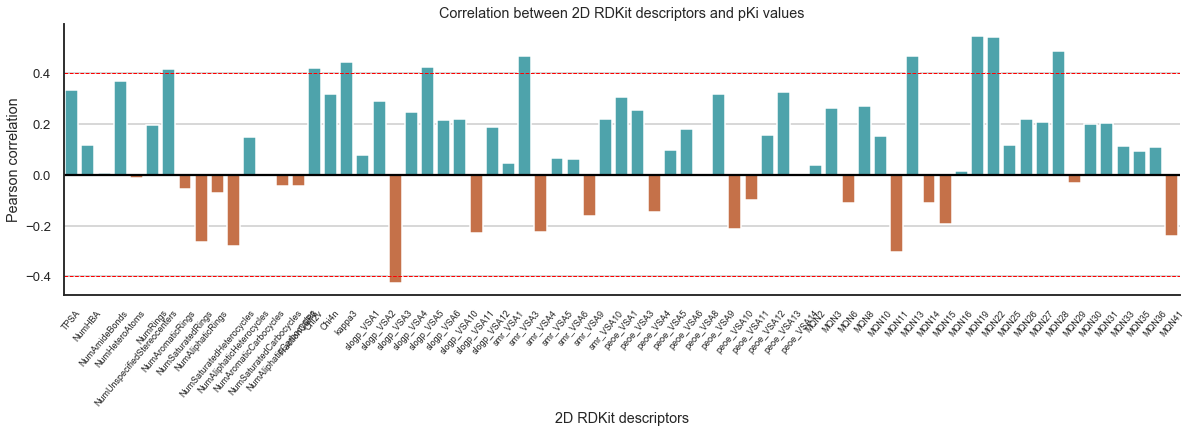

In [22]:
# plot  correlation values
color_palette = ['#3eb0ba' if i > 0 else '#da6a34' for i in df_rdk2d_corr_corr_pki.corr_pearson]
fig, ax = plt.subplots(figsize=(20, 5))

sns.barplot(x='descriptor', y = 'corr_pearson', data=df_rdk2d_corr_corr_pki, palette=color_palette, ax=ax)

ax.set_xticklabels(df_rdk2d_corr_corr_pki.descriptor, rotation=50, fontdict={'fontsize': 9})
ax.set(ylabel='Pearson correlation', xlabel='2D RDKit descriptors',
       title='Correlation between 2D RDKit descriptors and pKi values')
plt.grid(axis='y')
plt.axhline(color='k')
plt.axhline(y=0.4, linestyle='--', linewidth=1, color='red')
plt.axhline(y=-0.4, linestyle='--', linewidth=1, color='red')
sns.despine()
plt.show()

## Clustering (descriptors)

In [23]:
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering

For some reason, they cluster the 87 2D descriptors, not the 65 descriptors after correlation filtering (as they did with MACCS Keys).

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


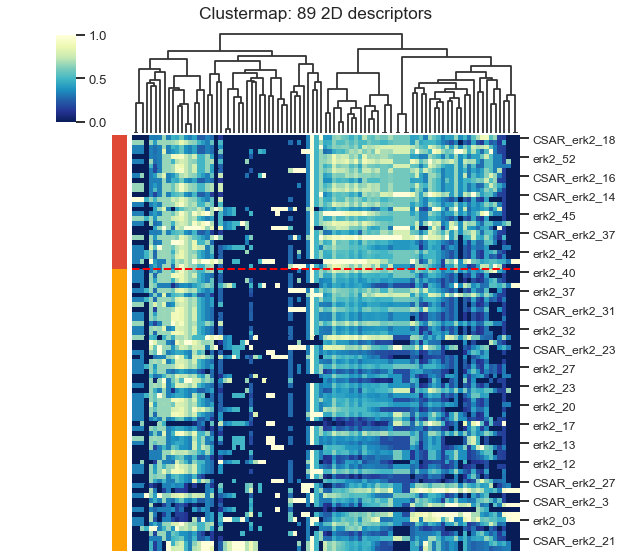

In [24]:
dist_euc_std = ssd.pdist(X_rdk2d_std.T, 'euclidean')
dist_euc_std = ssd.squareform(dist_euc_std)
link_euc = linkage(dist_euc_std, method='average', optimal_ordering=True)

colors_rows = ['#df4834' if i >= 7.5 else '#fda200' for i in df_erk2_mols['pKi']]

clusmap = sns.clustermap(X_rdk2d_std, cmap ='YlGnBu_r',
                standard_scale=1,
                row_cluster=False,
                col_linkage=link_euc,
                row_colors=colors_rows,
                cbar_pos=(0.1, .85, .03, .12),
                tree_kws={'linewidth': 1.8},
                figsize=(9, 10)
              )

# Number of actives
n_features = X_rdk2d_std.shape[1]
n_actives = sum(df_erk2_mols['pKi'] >= 7.5)
ax = clusmap.ax_heatmap
ax.set_yticklabels(clusmap.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
ax.hlines(y=n_actives, xmin=0, xmax=97, linewidth=2, linestyle='--', color = 'r')
clusmap.fig.suptitle(f'Clustermap: {n_features} 2D descriptors', y=1.01) 
ax.tick_params(labelbottom=False)
plt.show()

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


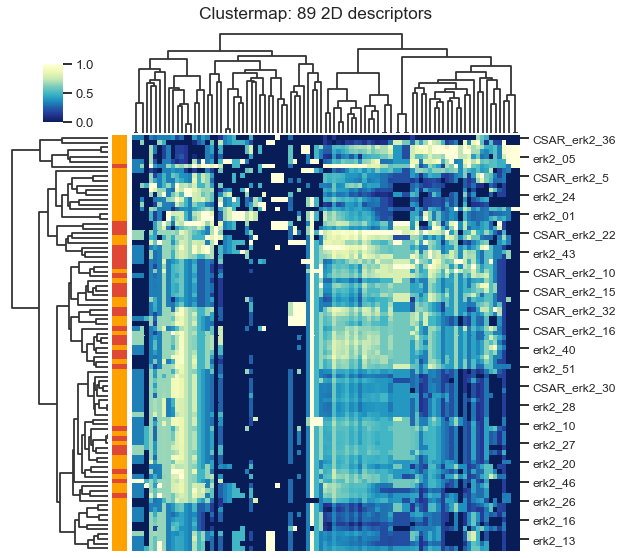

In [25]:
dist_euc_rows = ssd.pdist(X_rdk2d_std, 'euclidean')
link_euc_rows = linkage(ssd.squareform(dist_euc_rows), method='average', optimal_ordering=True)

clusmap = sns.clustermap(X_rdk2d_std, cmap ='YlGnBu_r',
                standard_scale=1,
                row_linkage=link_euc_rows,
                col_linkage=link_euc,
                col_cluster=True,
                row_colors=colors_rows,
                cbar_pos=(0.08, .85, .03, .08),
                tree_kws={'linewidth': 1.8},
                figsize=(9, 10)
              )

ax = clusmap.ax_heatmap
ax.set_xticklabels(clusmap.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(clusmap.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
clusmap.fig.suptitle(f'Clustermap: {n_features} 2D descriptors', y=1.01) 
ax.tick_params(labelbottom=False)
plt.show()

In [26]:
#### Now only using the 

## Paired t-test to compare Actives against Inactives

#### Supplementary Table S3

First, let's inspect the Table S3 from Ash & Fourches (2017), and count how many 2D descriptors they report as significative.

In [27]:
import tabula
pdf_sup_file = "./fourches_supp_material.pdf"
df_TS3_signif_descriptors = tabula.read_pdf(pdf_sup_file, pages = [10, 11], multiple_tables = False,
                                           pandas_options = {'header': None,
                                                            'names': ['descriptor_set', 'variable', 'p_value', 'cohens_D']})

In [28]:
df_TS3_2D_descriptors = df_TS3_signif_descriptors[df_TS3_signif_descriptors['descriptor_set'] == '2D'].reset_index()
print('Significative 2D RDKit Features found by Ash and Fourches.')
df_TS3_2D_descriptors.head()

Significative 2D RDKit Features found by Ash and Fourches.


,index,descriptor_set,variable,p_value,cohens_D
0,2,2D,Chi1n,0.000008,1.10
1,6,2D,kappa3,0.000050,1.00
2,7,2D,NumLipinskiHBD,0.000067,1.00
3,9,2D,MQN1,0.000150,0.98
4,11,2D,peoe_VSA1,0.000380,0.94


In [29]:
df_TS3_2D_descriptors.shape

(28, 5)

In their paper, Table 1 reports that 27 2D-RDkit descriptors were significative. However, the supplementary table S3 has 28 2D descriptors.

### Comparing Actives against inactives  given a descriptor's space

In their paper, Ash & Fourches mention that they used *paired t-test*, however, as far as I understood, we cannot apply this test because we are comparing different molecules (actives against inactives). They also do not mention if normality and, more importantly, homocedasticity was assumed, or if they used a Welsh ttest with Satterthwait degrees of freedom.

#### Homocedasticity: *Levene t-test*


#### Means comparison: *t-test*
> **Two-side t-test. Why two-tailed?** Because we don't know if, given a particular descriptor, it's mean with actives necessarily has to be greater than inactives mean. We're only interested in determine if the means are different.

> $H_0: \mu_{actives} = \mu_{inactives}$  
> $H_a: \mu_{actives} \neq \mu_{inactives}$

In [30]:
from scipy.stats import levene
from statsmodels.stats.weightstats import ttest_ind

### Effect size (Cohen's D value)

T-test effect size, proposed by Cohen (1998), indicates whether or not the the difference between two groups' averages is large enough to have a **practical** meaning, whether or not it's statistically significant. (Refs: [datanovia](https://www.datanovia.com/en/lessons/t-test-effect-size-using-cohens-d-measure/), [statwing](http://docs.statwing.com/examples-and-definitions/t-test/effect-size/)). The Cohen's $D$ value is computed as follows (for two independent samples):

> $D = \frac{\bar{x_{a}} - \bar{x_{b}}}{s_{pooled}}$,

> where  $s_{pooled} = \sqrt{\frac{\sum(x_a^i - \bar{x_a})^2 + \sum(x_b^i - \bar{x_b})^2}{n_a + n_b -2}}$

> and, in the case of Welch test (when variances equality can't be assumed):
> $s_{unequal} = \sqrt{\frac{1}{2}(var_a +var_b)}$

As we can see, Cohen's D value normalizes the differences between the means of the two samples to tell us how much they differ in terms of standard deviations.

#### Defining functions to compute Cohen's-d value

By double checking, we asserted that this function returns the same results as the `rstatix` library in R (there is an example below).

In [31]:
def calc_cohens_D(sample_a, sample_b, equal_var = True, ddof = 1):
    # Get the  sample means
    m_a = np.mean(sample_a)
    m_b = np.mean(sample_b)
    diff_m = abs(m_a - m_b)
    # If equal var
    if equal_var:
        n_a = len(sample_a)
        n_b = len(sample_b)
        pool_std = np.sqrt( ((n_a - ddof)*np.var(sample_a, ddof=ddof) + 
                             (n_b - ddof)*np.var(sample_b, ddof=ddof)) / (n_a + n_b - 2))
    else:
        pool_std = np.sqrt( (np.var(sample_a, ddof=ddof) + np.var(sample_b, ddof=ddof)) / 2)
    cohen_d = diff_m / pool_std
    # Determine the size effect
    effect_size = 'small' if cohen_d <= 0.2 else 'medium' if cohen_d <= 0.5 else 'large'
    return cohen_d, effect_size

#### Now compute all the statistics to all 2D descriptors

In [32]:
def calc_t_and_D_statistics(df, activity_array):
    '''
        df: A pandas tidy dataframe
        activity_array: a numpy array or pandas series with boolen values
    '''
    #Divide the main dataframe (after corr filtering) in two samples

    df_actives = df[activity_array == True]
    df_inactives = df[activity_array == False]

    # Create an empty dataframe])
    df_results = pd.DataFrame()

    # Iterate over all features
    for feature in df.columns:
        # Split the descriptor values bu molecules activity
        active_values = df_actives[feature]
        inactive_values = df_inactives[feature]

        #******* HOMOCEDASTICITY *******
        # Compute Levene test for homocedaticity
        w_statistic, l_p_value = levene(inactive_values, active_values,
                                      center='mean')
        if l_p_value > 0.05:
            homo_var = 'pooled' # H0 accepted, equal variances
            homocedastic = True
        else:
            homo_var = 'unequal'
            homocedastic = False

        # ******* t-TEST *********
        # compute the t-test
        t_statistic, t_pvalue, ddof = ttest_ind(inactive_values, active_values,
                                         alternative = 'two-sided',
                                         usevar = homo_var)

        # ******* Cohen's D value ******
        cohens_d, effect_size = calc_cohens_D(inactive_values, active_values, 
                                 equal_var = homocedastic) 
        # Append the results to the dataframe
        df_results = df_results.append({'Descriptor': feature, 
                           'levene_p_value': l_p_value, 'homocedastic': homocedastic, 
                           't_statistic': t_statistic, 't_p_value': t_pvalue,
                           'cohens_d_value':cohens_d, 'cohens_effect': effect_size},
                           ignore_index = True)

    df_results = df_results.set_index('Descriptor')
    df_results = df_results[['homocedastic', 'levene_p_value', 't_statistic',
                         't_p_value', 'cohens_d_value', 'cohens_effect']]
    df_results = df_results.sort_values(['cohens_d_value', 't_p_value'], ascending=False)
    return df_results

In [33]:
activity_array = df_erk2_mols.activity
df_2drkit_significance = calc_t_and_D_statistics(X_rdk2d_corr, activity_array)

### Benjamin-Hechberg correction (FDR method)

In [34]:
from statsmodels.stats.multitest import multipletests

In [35]:
hb = multipletests(df_2drkit_significance['t_p_value'], alpha=0.05,
                   is_sorted=False, method='fdr_bh')

df_2drkit_significance['BH_p_value'] = hb[1]
df_2drkit_significance['BH_passed'] = hb[0]
df_2drkit_significance.head()

,homocedastic,levene_p_value,t_statistic,t_p_value,cohens_d_value,cohens_effect,BH_p_value,BH_passed
Descriptor,,,,,,,,
MQN19,0.0,0.021476,-6.666379,4.718152e-09,1.440962,large,3.255525e-07,True
slogp_VSA5,1.0,0.704857,-5.363871,6.914257e-07,1.230929,large,2.385419e-05,True
MQN22,1.0,0.063727,-5.207437,1.314930e-06,1.195029,large,2.450919e-05,True
kappa3,1.0,0.397522,-5.188445,1.420823e-06,1.190671,large,2.450919e-05,True
Chi2v,1.0,0.906663,-5.133276,1.778009e-06,1.178011,large,2.453652e-05,True


### Which 2D descriptors significantly distinguish actives from inactives and have a 'large' Cohen's D value?
#### Our results

In [36]:
sig_2d_descriptors = df_2drkit_significance[df_2drkit_significance['BH_passed']].index
sig_2d_descriptors

Index(['MQN19', 'slogp_VSA5', 'MQN22', 'kappa3', 'Chi2v', 'MQN13',
       'NumHeteroAtoms', 'peoe_VSA1', 'TPSA', 'MQN28', 'peoe_VSA3',
       'peoe_VSA9', 'slogp_VSA4', 'Chi4n', 'MQN8', 'slogp_VSA10', 'slogp_VSA3',
       'slogp_VSA2', 'MQN27', 'NumHBA', 'MQN31', 'MQN26', 'NumAromaticRings',
       'MQN10', 'smr_VSA3', 'peoe_VSA12', 'smr_VSA10', 'peoe_VSA13',
       'slogp_VSA1', 'smr_VSA4'],
      dtype='object', name='Descriptor')

##### Ash & Fourches results

In [37]:
df_TS3_2D_descriptors.variable.values

array(['Chi1n', 'kappa3', 'NumLipinskiHBD', 'MQN1', 'peoe_VSA1',
       'NumHeteroAtoms', 'Chi2v', 'peoe_VSA9', 'MQN21', 'slogp_VSA5',
       'peoe_VSA7', 'kappa1', 'slogp_VSA4', 'slogp_VSA2', 'peoe_VSA3',
       'MQN28', 'smr_VSA3', 'peoe_VSA12', 'MQN8', 'slogp_VSA10',
       'smr_VSA1', 'MQN29', 'slogp_VSA3', 'smr_VSA4', 'MQN17', 'NumHBA',
       'MQN10', 'peoe_VSA4'], dtype=object)

##### Which are the same?
18 matched 2D descriptors.
The difference seems to be due the variables selected after correlation filtering.

In [38]:
np.array(list(set(sig_2d_descriptors) & set(df_TS3_2D_descriptors.variable.values)))

array(['Chi2v', 'MQN8', 'smr_VSA4', 'NumHeteroAtoms', 'NumHBA',
       'slogp_VSA10', 'kappa3', 'peoe_VSA3', 'MQN10', 'slogp_VSA3',
       'slogp_VSA4', 'slogp_VSA2', 'slogp_VSA5', 'MQN28', 'peoe_VSA1',
       'smr_VSA3', 'peoe_VSA12', 'peoe_VSA9'], dtype='<U14')

### Example of t-test comparison and Cohen's D value intuition

First, compute Cohen's D value using R:

In [39]:
activity = df_erk2_mols.activity

In [45]:
%%R -i X_rdk2d_std -i activity

library(dplyr)
descriptor_name = 'slogp_VSA5'
activity = as.vector(activity == 1)
descriptors <- X_rdk2d_std[descriptor_name]
descriptors['Activity'] <- activity
colnames(descriptors) <- c('descriptor', 'Activity')

# Compute cohens_d
descriptors %>% rstatix::cohens_d(descriptor ~ Activity, var.equal = TRUE)

# A tibble: 1 x 7
  .y.        group1 group2 effsize    n1    n2 magnitude
* <chr>      <chr>  <chr>    <dbl> <int> <int> <ord>    
1 descriptor FALSE  TRUE     -1.23    59    28 large    


#### Visualize

In [46]:
def plot_hist(df, descriptor):
    actives = df.loc[activity == True, descriptor]
    inactives = df.loc[activity == False, descriptor]
    
    # Statistics
    _, l_p_value = levene(inactives, actives, center='mean')
    homocedastic = l_p_value > 0.05
    homo_var = 'pooled' if homocedastic else 'unequal'
    _, t_pvalue, _ = ttest_ind(inactives, actives, alternative = 'two-sided', usevar = homo_var)
    cohens_d, effect_size = calc_cohens_D(inactives, actives, equal_var = homocedastic) 
    # Plot
    fig, ax = plt.subplots(figsize=(11, 5))
    for values, color, label in zip([actives, inactives],
                                    ['#f04f2c', '#339fa7'],
                                    ['Actives', 'Inactives']):
        mean = values.mean().round(1)
        std = values.std().round(2)
        sns.distplot(values, bins=8, norm_hist=False, ax=ax, color=color,
                     hist=True, label= f'{label}:\n mean = {mean}\n std = {std}',
                     rug=True,
                     hist_kws=dict(edgecolor="none"))
        # Draw menas and stds
        ax.axvline(x= values.mean(), color=color, linestyle='--', linewidth=3.5)
        ax.axvline(x= values.mean() - values.std(), color=color, linestyle=':', linewidth=2.5)
        ax.axvline(x= values.mean() + values.std(), color=color, linestyle=':', linewidth=2.5)
    ax.set(title=f"{descriptor} space\nt-test and Cohen's D value Actives vs Inactives",
           ylabel='Density', xlabel=f'{descriptor} values')
    x_pos = max(inactives)
    ax.text(0.8, 0.4, s=f"Homocedastic: {homocedastic}\nt-test p-value: {round(t_pvalue, 3)}\n" + \
            f"Cohen's D: {round(cohens_d, 2)}\nEffect size: {effect_size}",
            transform=ax.transAxes, fontsize=13)
    ax.legend()
    plt.show()

In [48]:
# def plot_hist(df, descriptor):
#     df = df.copy()
#     df['Activity']
    
#     df.groupby('Activity')
#     actives = df.loc[activity == True, descriptor]
#     inactives = df.loc[activity == False, descriptor]
    
#     # Statistics
#     _, l_p_value = levene(inactives, actives, center='mean')
#     homocedastic = l_p_value > 0.05
#     homo_var = 'pooled' if homocedastic else 'unequal'
#     _, t_pvalue, _ = ttest_ind(inactives, actives, alternative = 'two-sided', usevar = homo_var)
#     cohens_d, effect_size = calc_cohens_D(inactives, actives, equal_var = homocedastic) 
#     # Plot
#     fig, ax = plt.subplots(figsize=(11, 5))
#     for values, color, label in zip([actives, inactives],
#                                     ['#f04f2c', '#339fa7'],
#                                     ['Actives', 'Inactives']):
#         mean = values.mean().round(1)
#         std = values.std().round(2)
#         sns.distplot(values, bins=8, norm_hist=False, ax=ax, color=color,
#                      hist=True, label= f'{label}:\n mean = {mean}\n std = {std}',
#                      rug=True,
#                      hist_kws=dict(edgecolor="none"))
#         # Draw menas and stds
#         ax.axvline(x= values.mean(), color=color, linestyle='--', linewidth=3.5)
#         ax.axvline(x= values.mean() - values.std(), color=color, linestyle=':', linewidth=2.5)
#         ax.axvline(x= values.mean() + values.std(), color=color, linestyle=':', linewidth=2.5)
#     ax.set(title=f"{descriptor} space\nt-test and Cohen's D value Actives vs Inactives",
#            ylabel='Density', xlabel=f'{descriptor} values')
#     x_pos = max(inactives)
#     ax.text(0.8, 0.4, s=f"Homocedastic: {homocedastic}\nt-test p-value: {round(t_pvalue, 3)}\n" + \
#             f"Cohen's D: {round(cohens_d, 2)}\nEffect size: {effect_size}",
#             transform=ax.transAxes, fontsize=13)
#     ax.legend()
#     plt.show()

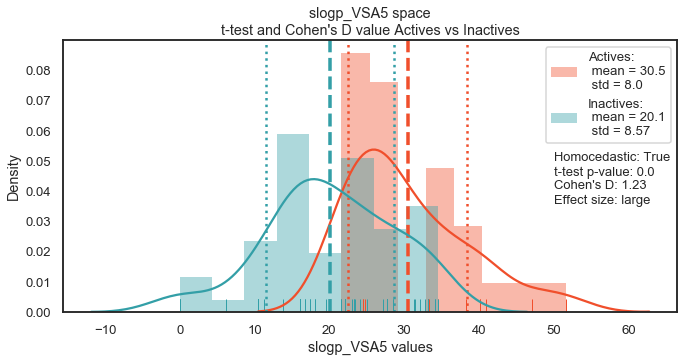

In [49]:
plot_hist(X_rdk2d_var, 'slogp_VSA5') # Note we are using the values without standarization

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


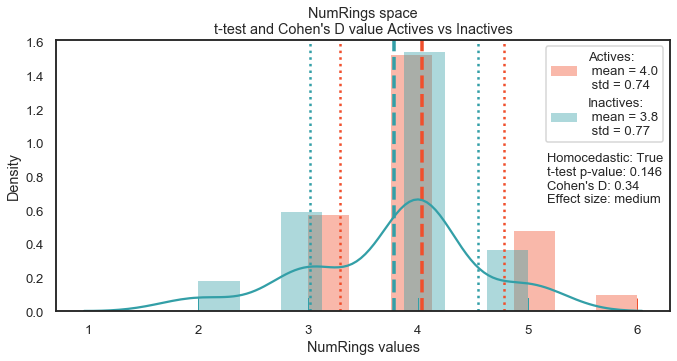

In [50]:
plot_hist(X_rdk2d_var, 'NumRings') # Note we are using the values without standarization

## Activity Cliffs

Ash & Fourches defined an Activity Cliff between a pair of ligands (in an descriptor space) as an event in which two given molecules have an absolute difference in pKi greater than 1.5 having a Tanimoto dissimilarity of less than 0.2 (for fingerprints) or an Euclidian distance less than 6.

### Euclidian distance matrix
Compute the  euclidean distance matrix using the remaining descriptors previously standarized (z-score)

In [51]:
import scipy.spatial.distance as ssd

In [52]:
euc_2drdk_mtx = ssd.pdist(X_rdk2d_corr, metric='euclidean')
euc_2drdk_mtx = ssd.squareform(euc_2drdk_mtx)

### pKi Deltas matrix

In [53]:
# Compute a matrix with the absolute Delta pKi values between each pair of molecules
n_mols = df_erk2_mols.shape[0]
pki_vector = df_erk2_mols.pKi.values
delta_pki_matrix = np.zeros((n_mols, n_mols))
for i in range(n_mols):
    for j in range(n_mols):
        deltas = np.abs(pki_vector[i] - pki_vector)
        # Fill the matrix
        delta_pki_matrix[i, :] = deltas

### Visualization

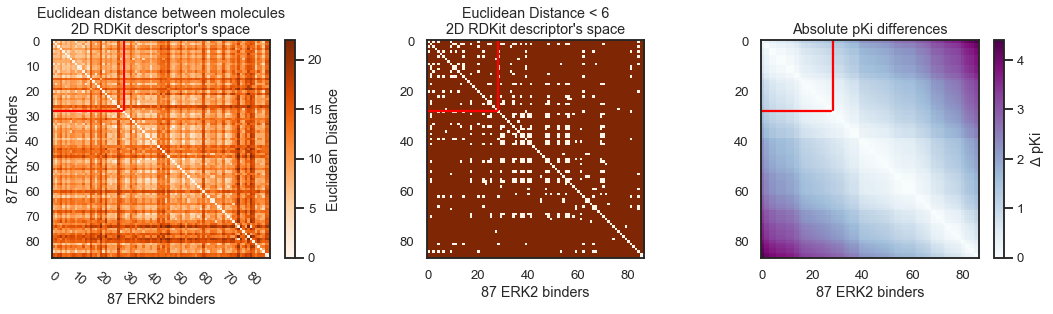

In [54]:
n_actives = df_erk2_mols.activity.sum()

fig = plt.figure(figsize=(18, 4))

plt.subplot(1,3,1)
plt.imshow(euc_2drdk_mtx, cmap='Oranges')
plt.yticks(range(0, n_mols, 10))
plt.xticks(range(0, n_mols, 10), rotation=-40)
xlabel_ = f'{n_mols} ERK2 binders'
plt.xlabel(xlabel_); plt.ylabel(xlabel_)
plt.title("Euclidean distance between molecules\n2D RDKit descriptor's space")

plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')

cbar1 = plt.colorbar()
cbar1.set_label('Euclidean Distance')


# Euclidean distance threshold (< 6)
plt.subplot(1,3,2)
euc_dist_threshold = euc_2drdk_mtx < 6
# Just for visualization fill the diagonal
plt.imshow(euc_dist_threshold, cmap='Oranges_r')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.xlabel(xlabel_)
plt.title("Euclidean Distance < 6\n2D RDKit descriptor's space")


# pKi deltas
plt.subplot(1,3,3)
# Just for visualization fill the diagonal
plt.imshow(delta_pki_matrix, cmap='BuPu')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.xlabel(xlabel_)
plt.title('Absolute pKi differences')

cbar2 = plt.colorbar()
cbar2.set_label('$\Delta$ pKi')

plt.show()

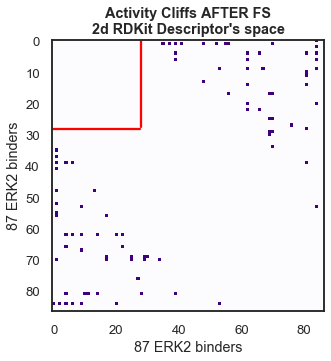

In [59]:
euclidean_mtx_dist_threshold = euc_dist_threshold & (delta_pki_matrix > 1.5)

fig = plt.figure(figsize=(5, 5))

plt.imshow(euclidean_mtx_dist_threshold, cmap='Purples')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.title("Activity Cliffs AFTER FS\n2d RDKit Descriptor's space", fontweight='bold')
plt.xlabel(xlabel_); plt.ylabel(xlabel_)
plt.show()

## Circular Dendrograms

In [87]:
# pKis
pki_values = df_erk2_mols.pKi
# Activities
activity_array = df_erk2_mols.activity.values
# Distance matrix
distance_mtx = euc_2drdk_mtx
# Dataframe
df_to_R = X_rdk2d_corr.copy()
#
print(f'Num. features: {df_to_R.shape[1]}')
df_to_R.index =[i.replace('CSAR_erk2', 'CSAR') for i in df_to_R.index]
df_to_R.index =[i.replace('erk2_', 'mod_') for i in df_to_R.index]

pki_values.shape

Num. features: 69


(87,)

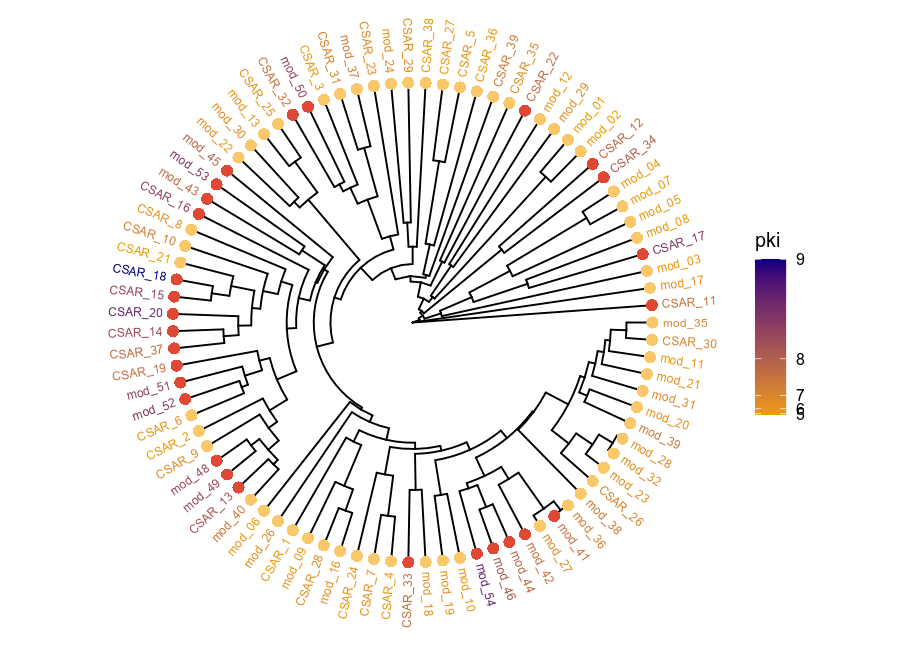

In [89]:
%%R -i df_to_R -i activity_array  -i pki_values -w 7 -h 5 --units in -r 130
library(ggtree)
library(ggplot2)
library(dendextend)

# The autors said they used fastclust for clustering and ggtree to draw the circular dendograms
df_maccs <- df_to_R

# Parse the distance matrix and perform the clustering using fastcluster
dist_matx <- vegan::vegdist(df_maccs, method = 'euclidean') #

# # Perform hierarchical clustering using fastcluster
clust <- fastcluster::hclust(dist_matx, method='average')

dendrogram <- ape::as.phylo(clust)

# Activity colors: Red = active
activity_array[activity_array == 1] <- '#df4834'
activity_array[activity_array == 0] <- '#fac76b'
pki_vector = as.vector(pki_values)

df_tree = data.frame(taxa = clust$labels, pki = pki_vector)
row.names(df_tree) <- NULL

tree <- ggtree(dendrogram, layout='circular', ladderize=T) %<+% 
        df_tree + 
        geom_tiplab(aes(color=pki), offset = 0.3, size = 2.3 ) +
        scale_color_gradient(low='orange2', high='navyblue', trans='exp') + 
        geom_tippoint(color= activity_array, shape=16, size=2.8)
tree

***

## Activity Cliffs Before and After Feature Selection

## TO DO:
#### It has no sense to compare euclidean distances AFTER and BEFORE Feature selection because the difference in the number of dimensions affects the threshold, because euclidean distance increases with the number of features.

In [228]:
metric = 'euclidean'
cutoff_dist = 6

X_rdk2d_ALL_std = StandardScaler().fit_transform(X_rdk2d)
euc_2drdk_mtx_BEFORE = ssd.pdist(X_rdk2d_ALL_std, metric= metric)
euc_2drdk_mtx_BEFORE = ssd.squareform(euc_2drdk_mtx_BEFORE)


euc_2drdk_mtx_AFTER = ssd.pdist(X_rdk2d_corr, metric= metric)
euc_2drdk_mtx_AFTER = ssd.squareform(euc_2drdk_mtx_AFTER)


# BEFORE FEATURE SELECTION
euclidean_mtx_dist_threshold_BEFORE = (euc_2drdk_mtx_BEFORE < cutoff_dist) & (delta_pki_matrix > 1.5)

# AFTER FEATURE SELECTION
euclidean_mtx_dist_threshold_AFTER = (euc_2drdk_mtx_AFTER < cutoff_dist - 2) & (delta_pki_matrix > 1.5)

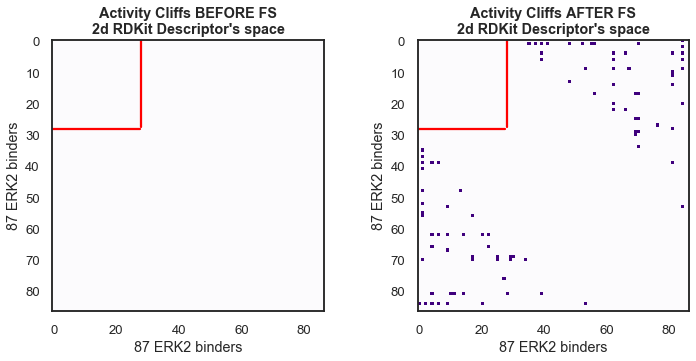

In [229]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.imshow(euclidean_mtx_dist_threshold_BEFORE, cmap='Purples')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.title("Activity Cliffs BEFORE FS\n2d RDKit Descriptor's space", fontweight='bold')
plt.xlabel(xlabel_); plt.ylabel(xlabel_)

plt.subplot(1,2,2)
plt.imshow(euclidean_mtx_dist_threshold, cmap='Purples')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.title("Activity Cliffs AFTER FS\n2d RDKit Descriptor's space", fontweight='bold')
plt.xlabel(xlabel_); plt.ylabel(xlabel_)
plt.show()

### Use PCA to start the EDA: 
#### Just for visualization purposes before preprocessing and feature selection

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=2)
pca_pipe = Pipeline(steps = [('scaler', scaler), ('pca', pca)])

X_rdk2d = df_rdkit_all
pca_pipe.fit(X_rdk2d)
# Components
components = pca_pipe.transform(X_rdk2d).T
# Variance ratio
var_ = pca_pipe['pca'].explained_variance_ratio_.round(3) * 100

In [ ]:
# Create a dataframe to plot the values
df_pca = df_erk2_mols[['activity', 'pKi']].copy()
df_pca['activity'] = ['active' if i else 'inactive' for i in df_pca.activity]
df_pca['pc1'] = components[0]
df_pca['pc2'] = components[1]

# Plot the PCS
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvline(linestyle='--', color='k')
ax.axhline(linestyle='--', color='k')
sns.scatterplot(x='pc1', y='pc2', hue='activity', size='pKi', data=df_pca, 
                ax=ax, palette=['#df4834', '#fda200'], edgecolor='k', alpha=0.8)
ax.set(title='PCA: 160 RDKit 2D descriptors',
      xlabel=f'PC 1 ({var_[0]}%)', ylabel=f'PC2 ({var_[1]}%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='--')
plt.show()

### Feature Standarization

In [ ]:
scaler = StandardScaler()
X_rdk2d_std = pd.DataFrame(scaler.fit_transform(X_rdk2d), columns=X_rdk2d.columns, index=X_rdk2d.index)
X_rdk2d_std

In [ ]:
from correlation_filter import *
# Compute the correlation matrix
df_full_corr = X_rdk2d_std.corr(method='pearson')
# Drop high correlated features
features_to_drop_rdk2d = features_to_drop(dataset=X_rdk2d_std, correlated_mtx = df_full_corr, 
                         max_thr = 1, min_thr = 0.9, step =  0.01, verbose = False, absoluted=True)